<a href="https://colab.research.google.com/github/Cloud2602/gesture_recognition/blob/main/gesture_recognition_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


In [1]:
!unzip -q "/content/dataset-hands.zip" -d "/content/dataset_hands"

### Landmark Extraction

In [11]:
import os
import cv2
import mediapipe as mp
import numpy as np
import csv

# Percorsi
DATASET_DIR = "/content/dataset_hands/dataset-hands/0"  # Sostituisci con il percorso corretto
output_csv = "0.csv"
output_npy = "0.npy"

# Setup MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

# Output
all_landmarks = []
# Header aggiornato: mano destra da x0 a z20, mano sinistra da x0_L a z20_L
header = []

# Mano destra
header += [f'{dim}{i}_R' for i in range(21) for dim in ['x', 'y', 'z']]
# Mano sinistra
header += [f'{dim}{i}_L' for i in range(21) for dim in ['x', 'y', 'z']]

with open(output_csv, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(header)

    for filename in sorted(os.listdir(DATASET_DIR)):
        if not filename.endswith("_Color.png"):
            continue

        image_path = os.path.join(DATASET_DIR, filename)
        image_bgr = cv2.imread(image_path)
        if image_bgr is None:
            print(f"❌ Errore caricamento: {filename}")
            continue

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        # Landmark inizializzati a zero
        right_hand = [0.0] * (21 * 3)
        left_hand = [0.0] * (21 * 3)

        if results.multi_hand_landmarks and results.multi_handedness:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                label = handedness.classification[0].label  # "Left" o "Right"
                if label == "Right":
                  label= "Left"
                else:
                  label= "Right"
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                if label == "Right":
                    right_hand = landmarks
                else:
                    left_hand = landmarks

        # Righe composte da mano destra + mano sinistra
        combined = right_hand + left_hand
        print(f"Image-path: {image_path}")
        print(f"Landmarks: {combined}")
        all_landmarks.append(combined)
        csv_writer.writerow(combined)

# Salvataggio finale
np.save(output_npy, np.array(all_landmarks))
print(f"✅ Landmark salvati in {output_csv} e {output_npy}")


Image-path: /content/dataset_hands/dataset-hands/0/10_Color.png
Landmarks: [0.39540496468544006, 0.9303646087646484, 3.815804063833639e-07, 0.4490165412425995, 0.9028010964393616, -0.030264217406511307, 0.4852159023284912, 0.8281635046005249, -0.042100660502910614, 0.5048149824142456, 0.762987494468689, -0.050761859863996506, 0.516677737236023, 0.7087280750274658, -0.05963912233710289, 0.4548366665840149, 0.7161239981651306, -0.032369859516620636, 0.4589531719684601, 0.6275103688240051, -0.05401930212974548, 0.46058738231658936, 0.570243775844574, -0.07115663588047028, 0.45969024300575256, 0.5182307958602905, -0.08410953730344772, 0.4160952568054199, 0.7087362408638, -0.032948851585388184, 0.41699689626693726, 0.6109389066696167, -0.05458319932222366, 0.4189606308937073, 0.5459405183792114, -0.07289814949035645, 0.4190821945667267, 0.48950302600860596, -0.08584252744913101, 0.37932732701301575, 0.7235237956047058, -0.036747630685567856, 0.3728916049003601, 0.631083071231842, -0.0584964

### Add Augumentation

In [13]:
import os
import numpy as np

# === Funzioni di Data Augmentation ===

def flip_two_hands(landmarks_flat):
    """
    Input: landmarks_flat shape (42, 3) = [right(21), left(21)]
    Output: flipped + swapped hands
    """
    landmarks = landmarks_flat.reshape((42, 3)).copy()

    # Flip x (orizzontale)
    landmarks[:, 0] = 1.0 - landmarks[:, 0]

    # Swap le mani: prima sinistra (21:42), poi destra (0:21)
    landmarks_flipped = np.vstack((landmarks[21:], landmarks[:21]))

    return landmarks_flipped


def zoom_landmarks(landmarks, scale=0.8):
    center = landmarks[0]
    return (landmarks - center) * scale + center

def rotate_landmarks(landmarks, angle_deg=15):
    angle_rad = np.radians(angle_deg)
    center = landmarks[0]
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])
    rotated = np.dot(landmarks[:, :2] - center[:2], rotation_matrix) + center[:2]
    landmarks[:, :2] = rotated
    return landmarks

def translate_landmarks(landmarks, offset=(0.05, -0.03, 0.0)):
    return landmarks + np.array(offset)

# === Percorsi da modificare ===
input_base_dir = "/content/mediapipe_landmarks_two_hands"
output_base_dir = "/content/data_augumented"

os.makedirs(output_base_dir, exist_ok=True)

# === Elaborazione dei file ===
for file_name in sorted(os.listdir(input_base_dir)):

            if file_name.endswith('.npy'):
                print(f"✔️ File: {file_name}")
                file_path = os.path.join(input_base_dir, file_name)
                landmarks = np.load(file_path)
                augmented = []
                for i, landmark in enumerate(landmarks):

                  landmark = landmark.reshape((42, 3))  # Converti in (42, 3)
                  # Lista delle versioni aumentate

                  augmented.append(landmark.copy())

                  # Flip
                  augmented.append(flip_two_hands(landmark.copy()))

                  # Zoom out
                  augmented.append(zoom_landmarks(landmark.copy(), scale=0.8))

                  # Rotazioni
                  augmented.append(rotate_landmarks(landmark.copy(), angle_deg=15))
                  augmented.append(rotate_landmarks(landmark.copy(), angle_deg=-15))

                  # Traslazioni
                  augmented.append(translate_landmarks(landmark.copy(), offset=(0.05, -0.03, 0.0)))
                  augmented.append(translate_landmarks(landmark.copy(), offset=(-0.05, 0.03, 0.0)))
            else:
                print(f"⚠️ File non valido: {file_name}")

            print("augumented lenght: ", len(augmented))
            new_name = f"{os.path.splitext(file_name)[0]}.npy"
            save_path = os.path.join(output_base_dir, new_name)
            np.save(save_path, augmented)
            print(f"✔️ File salvato: {save_path}")

✔️ File: 0.npy
augumented lenght:  490
✔️ File salvato: /content/data_augumented/0.npy
✔️ File: 1.npy
augumented lenght:  490
✔️ File salvato: /content/data_augumented/1.npy
✔️ File: 2.npy
augumented lenght:  490
✔️ File salvato: /content/data_augumented/2.npy
✔️ File: 3.npy
augumented lenght:  490
✔️ File salvato: /content/data_augumented/3.npy


In [14]:
import shutil
from google.colab import files


# Crea un file ZIP chiamato data_augumented.zip a partire dalla cartella
shutil.make_archive("/content/data_augumented", 'zip', "/content/data_augumented")

# Scarica il file ZIP sul tuo computer
files.download("/content/data_augumented.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
!git clone https://github.com/Cloud2602/gesture_recognition.git

Cloning into 'gesture_recognition'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (376/376), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 376 (delta 156), reused 282 (delta 97), pack-reused 0 (from 0)
Receiving objects: 100% (376/376), 38.58 MiB | 21.32 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (262/262), done.


In [ ]:
%cd /content/gesture_recognition
!git pull

/content/gesture_recognition
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 66 (delta 23), reused 51 (delta 12), pack-reused 0 (from 0)
Unpacking objects: 100% (66/66), 703.60 KiB | 2.67 MiB/s, done.
From https://github.com/Cloud2602/gesture_recognition
   c5ef690..c453b07  main       -> origin/main
Updating c5ef690..c453b07
Fast-forward
 .gitignore                                         |   3 +-
 .vsconfig                                          |   6 +
 Assets/.vs/slnx.sqlite                             | Bin 0 -> 90112 bytes
 Assets/Scenes/WebcamIntegration.unity              | 588 +++++++++++++++++++++
 Assets/Scenes/WebcamIntegration.unity.meta         |   7 +
 Assets/Scripts.meta                                |   8 +
 Assets/Scripts/HeartRotator.cs                     |  42 ++
 Assets/Scripts/HeartRotator.cs.meta                |  11 +
 Assets/WebcamDisplay.cs                  

In [ ]:
!pip install tensorflow

In [ ]:
%cd ..

/content


In [17]:
!python /content/gesture_recognition/train.py

2025-06-23 10:50:55.389939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750675855.414937   20659 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750675855.422144   20659 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-23 10:50:59.766649: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call 

✅ Modello caricato!


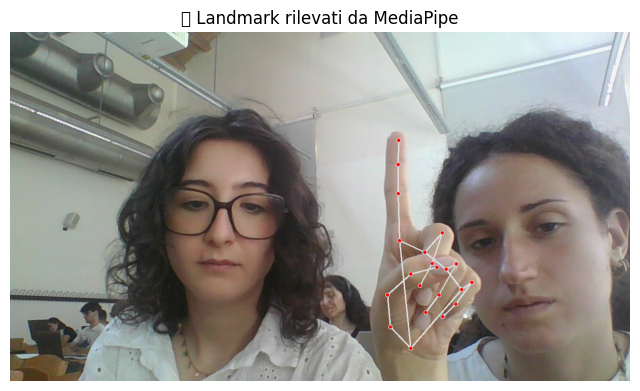

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
📈 Output del modello: [[0.48624852 0.12480384 0.18581471 0.20313291]]
🔢 Classe predetta: 0


In [21]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# === CONFIGURAZIONE ===
model_path = '/content/best_model.h5'
image_path = '/content/WIN_20250623_12_57_23_Pro.jpg'  # <-- Cambia con il tuo file
input_size = 126  # 21 punti x 3 coordinate x 2 mani

# === CARICA MODELLO ===
model = load_model(model_path)
print("✅ Modello caricato!")

# === SETUP MEDIAPIPE ===
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

# === CARICA IMMAGINE ===
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise FileNotFoundError(f"❌ Immagine non trovata: {image_path}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# === ESTRAZIONE LANDMARK ===
results = hands.process(image_rgb)

# Landmark inizializzati a zero (come nel training)
right_hand = [0.0] * (21 * 3)
left_hand = [0.0] * (21 * 3)
annotated_image = image_bgr.copy()
if results.multi_hand_landmarks and results.multi_handedness:
    for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
        mp_drawing.draw_landmarks(
              annotated_image,
              hand_landmarks,
              mp_hands.HAND_CONNECTIONS
          )
        label = handedness.classification[0].label  # "Left" o "Right"
        if label == "Right":
          label= "Left"
        else:
          label= "Right"
        landmarks = []
        for lm in hand_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])
        if label == "Right":
            right_hand = landmarks
        elif label == "Left":
            left_hand = landmarks


# === MOSTRA IMMAGINE CON LANDMARK ===
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("🖐️ Landmark rilevati da MediaPipe")
plt.axis("off")
plt.show()

# === COMBINA E PREPARA INPUT ===
combined = right_hand + left_hand
input_data = np.array([combined])  # shape: (1, 126)

# === PREDIZIONE ===
prediction = model.predict(input_data)
predicted_class = np.argmax(prediction)

# === RISULTATI ===
print("📈 Output del modello:", prediction)
print("🔢 Classe predetta:", predicted_class)



In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, np.argmax(y_train, axis=1))
print("Test accuracy:", clf.score(X_test, np.argmax(y_test, axis=1)))
